### Monte Carlo Control Algorithm for GridWorld Problem

In [102]:
from enum import Enum
import random
import matplotlib.pyplot as plt
import numpy as np

#### Enviroment
Model represeting enviroment of Grid World, where agent need to find the best path to reward.

In [103]:
class Action(Enum):
    UP = 'UP'
    DOWN = "DOWN"
    LEFT = "LEFT"
    RIGHT = "RIGHT"
    
CONST_PENALTY = -0.1   

env = {
    ((0,0), Action.DOWN) : [(1., ((0,1), CONST_PENALTY))],
    ((0,0), Action.RIGHT) : [(1., ((1,0), CONST_PENALTY))],
    ((1,0), Action.LEFT) : [(1., ((0,0), CONST_PENALTY))],
    ((1,0), Action.RIGHT) : [(1., ((2,0), CONST_PENALTY))],
    ((2,0), Action.LEFT) : [(1., ((1,0), CONST_PENALTY))],
    ((2,0), Action.RIGHT) : [(.1, ((3,0), 1.)), (.9, ((1,0), CONST_PENALTY))],
    ((2,0), Action.DOWN) : [(1., ((2,1), CONST_PENALTY))],
    ((0,1), Action.DOWN) : [(1., ((0,2), CONST_PENALTY))],
    ((0,1), Action.UP) : [(1., ((0,0), CONST_PENALTY))],
    ((2,1), Action.UP) : [(.7, ((2,0), CONST_PENALTY)), (.3, ((3,1), -1.))],
    ((2,1), Action.DOWN) : [(1., ((2,1), CONST_PENALTY))],
    ((2,1), Action.RIGHT) : [(1., ((3,1), -1.))],
    ((0,2), Action.UP) : [(1., ((0,1), CONST_PENALTY))],
    ((0,2), Action.RIGHT) : [(1., ((1,2), CONST_PENALTY))],
    ((1,2), Action.RIGHT) : [(1., ((2,2), CONST_PENALTY))],
    ((1,2), Action.LEFT) : [(1., ((0,2), CONST_PENALTY))],
    ((2,2), Action.RIGHT) : [(1., ((3,2), CONST_PENALTY))],
    ((2,2), Action.LEFT) : [(1., ((1,2), CONST_PENALTY))],
    ((2,2), Action.UP) : [(1., ((2,1), CONST_PENALTY))],
    ((3,2), Action.LEFT) : [(1., ((2,2), CONST_PENALTY))],
    ((3,2), Action.UP) : [(1., ((3,1), -1.))],
}

actions = {
    (0,0) : {Action.DOWN, Action.RIGHT},
    (1,0) : {Action.LEFT, Action.RIGHT},
    (2,0) : {Action.LEFT, Action.RIGHT, Action.DOWN},
    (3,0) : {},
    (0,1) : {Action.UP, Action.DOWN},
    (2,1) : {Action.UP, Action.DOWN, Action.RIGHT},
    (3,1) : {},
    (0,2) : {Action.UP, Action.RIGHT},
    (1,2) : {Action.RIGHT, Action.LEFT},
    (2,2) : {Action.RIGHT, Action.LEFT, Action.UP},
    (3,2) : {Action.LEFT, Action.UP}
}

def env_return(state, action):
    probabilities, return_value = zip(*env[(state, action)])
    return random.choices(return_value, weights=probabilities, k=1)[0]  

#### Policy
Initiated as random allowed action for each state.

In [104]:
def get_random_policy():    
    policy = {}
    for state, allowed_actions in actions.items():
        if allowed_actions:
            policy[state] = random.choice(list(allowed_actions))
    return policy

In [105]:
def display_policy_on_board(policy):
    rows, cols = 3, 4
    grid = [[" " for _ in range(cols)] for _ in range(rows)]
    
    action_symbols = {
        Action.UP: "↑",
        Action.DOWN: "↓",
        Action.LEFT: "←",
        Action.RIGHT: "→"
    }

    for (x, y), action in policy.items():
        grid[y][x] = action_symbols[action]

    for row in grid:
        print(" | ".join(row))

#### Action value function
Represented by map. Includes current action value mean and current number of examples (examples number for updating mean)

In [106]:
def get_Q(init_value):    
    Q = {}
    for (state, action) in env:
        if init_value != None:
            Q[(state, action)] = (init_value, 1)
        else:
            Q[(state, action)] = (0,0)
    return Q
    

Plays episode base on given init state and action than follows the policy. Return history of states-actions and rewards for them.

In [107]:
def play_episode(policy, init_state, epsilon):
    states_actions = []
    rewards = []
    current_state = init_state
    while len(actions[current_state]) > 0:
        if(random.random() > epsilon):
            action = policy[current_state]
        else:
            action = random.choice(list(actions[current_state]))
        next_state, reward = env_return(state=current_state, action=action)
        states_actions.append((current_state, action))
        rewards.append(reward)
        current_state = next_state
    return (states_actions, rewards) 

Update policy base on current max mean from Action Value Function (Q) (for each state)

In [108]:
def update_policy(policy, Q):
    for state in policy:
        max_mean = float('-inf')
        max_action = None
        for action in actions[state]:
            mean_Q, _ = Q[(state, action)]
            if mean_Q > max_mean:
                max_mean = mean_Q
                max_action = action
        if max_action != None:
            policy[state] = max_action

Plays a few episodes and updates Action Value Function mean base on result. Then updating policy.

In [113]:
def train_agent(policy, Q, gamma, epsilon, init_state=(0,2)):
    delta_history = []
    rewards_history = []
    for _ in range(10_000):
        states_actions, rewards = play_episode(
            policy=policy,
            init_state=init_state,
            epsilon=epsilon
        )
        G = 0
        max_delta = 0
        for t in reversed(range(len(states_actions))):
            G = rewards[t] + gamma*G
            mean_Q, N_Q = Q[states_actions[t]]
            new_mean_Q = (N_Q * mean_Q + G)/(N_Q + 1)
            max_delta = max(max_delta, np.abs(mean_Q - new_mean_Q)) # For statistic
            Q[states_actions[t]] = (new_mean_Q, N_Q + 1)
        update_policy(policy=policy, Q=Q)
        delta_history.append(max_delta)
        rewards_history.append(sum(rewards))

    return policy, Q, delta_history, rewards_history

In [134]:
policy, Q, delta_history, rewards_history = train_agent(policy=get_random_policy(), Q=get_Q(init_value=1), epsilon=.01, gamma=.1)
display_policy_on_board(policy)

→ | → | → |  
↑ |   | ↓ |  
↑ | ← | ↑ | ←


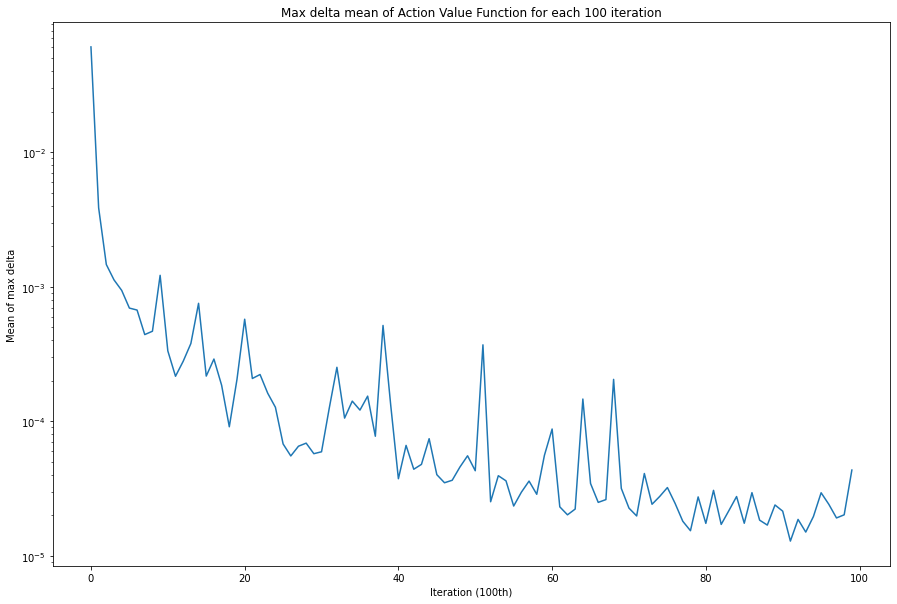

In [135]:
samples = 100
delta_means = [np.mean(delta_history[i:i+samples]) for i in range(0, len(delta_history), samples)]

plt.figure(figsize=(15, 10))
plt.plot(delta_means)

plt.title('Max delta mean of Action Value Function for each 100 iteration')
plt.xlabel('Iteration (100th)')
plt.ylabel('Mean of max delta')

plt.yscale('log')

plt.show()

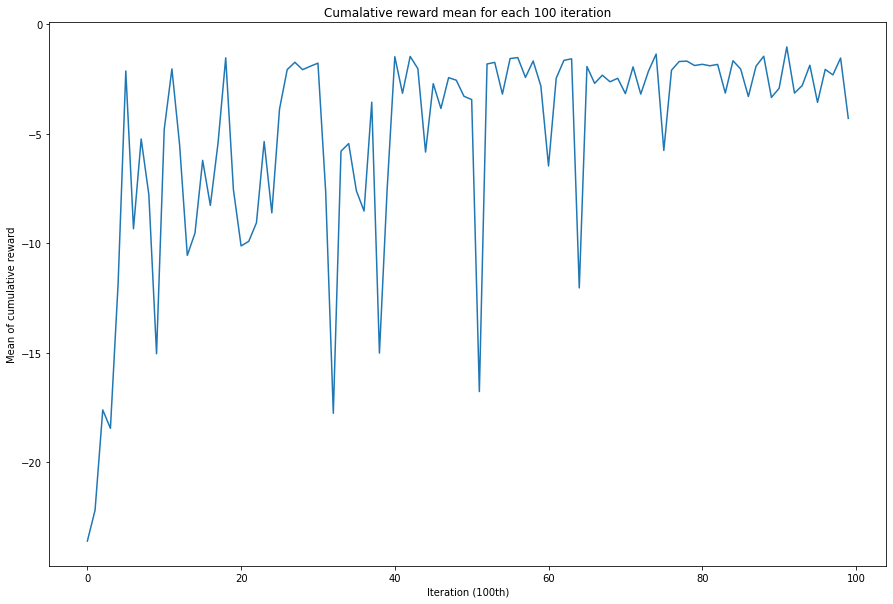

In [136]:
samples = 100
reward_means = [np.mean(rewards_history[i:i+samples]) for i in range(0, len(rewards_history), samples)]

plt.figure(figsize=(15, 10))
plt.plot(reward_means)

plt.title('Cumalative reward mean for each 100 iteration')
plt.xlabel('Iteration (100th)')
plt.ylabel('Mean of cumulative reward')

plt.show()

In [137]:
display(Q)

{((0, 0), <Action.DOWN: 'DOWN'>): (-0.11042679787958516, 1625),
 ((0, 0), <Action.RIGHT: 'RIGHT'>): (-0.11003505606424074, 9871),
 ((1, 0), <Action.LEFT: 'LEFT'>): (-0.11043348007642795, 1711),
 ((1, 0), <Action.RIGHT: 'RIGHT'>): (-0.1000229542276926, 85860),
 ((2, 0), <Action.LEFT: 'LEFT'>): (-0.10849801461215178, 520),
 ((2, 0), <Action.RIGHT: 'RIGHT'>): (0.0007439610022761323, 85734),
 ((2, 0), <Action.DOWN: 'DOWN'>): (-0.10833123569088339, 329),
 ((0, 1), <Action.DOWN: 'DOWN'>): (-0.11090654741237994, 5432),
 ((0, 1), <Action.UP: 'UP'>): (-0.11090529116868501, 9785),
 ((2, 1), <Action.UP: 'UP'>): (-0.3735869770694707, 1039),
 ((2, 1), <Action.DOWN: 'DOWN'>): (-0.11154075707990821, 322981),
 ((2, 1), <Action.RIGHT: 'RIGHT'>): (-0.9982158786797503, 1121),
 ((0, 2), <Action.UP: 'UP'>): (-0.1110227867428262, 13592),
 ((0, 2), <Action.RIGHT: 'RIGHT'>): (-0.11102311447060886, 12520),
 ((1, 2), <Action.RIGHT: 'RIGHT'>): (-0.11101057151737938, 10117),
 ((1, 2), <Action.LEFT: 'LEFT'>): (-0.